<a href="https://colab.research.google.com/github/ranadeepbhuyan/cancer-mri-analysis/blob/main/Detectionoftumor'sfunctional_area_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import os
from matplotlib.gridspec import GridSpec
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
based_path_tumor = r"/content/drive/MyDrive/PKG - UPENN-GBM 3d to 2d /along z/tumor_image_64_part"
based_path_brain_with_tumor = r"/content/drive/MyDrive/PKG - UPENN-GBM 3d to 2d /along z/dataset_64part_each_2dimg"

In [ ]:
#fatching ids form data path
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x


train_data_ids_tumor = [f.path for f in os.scandir(based_path_tumor)]
train_data_ids_brain = [f.path for f in os.scandir(based_path_brain_with_tumor)]

In [ ]:
train_ids_tumor=[]
for i in train_data_ids_tumor:
  test = i.split(based_path_tumor + '/')[1]
  train_ids_tumor.append(test)

In [ ]:
train_ids_tumor[0]

'095_z_25.png'

In [ ]:
train_ids_brain=[]
for i in train_data_ids_brain:
  test = i.split(based_path_brain_with_tumor + '/')[1]
  train_ids_brain.append(test)

In [ ]:
train_ids_brain[0]

'124_z_25.png'

In [ ]:
len(train_ids_tumor)

5184

In [ ]:
len(train_ids_brain)

8960

In [ ]:
train_ids= []
for i in train_ids_brain:
  if i in train_ids_tumor:
    train_ids.append(i)

In [ ]:
len(train_ids)

5184

In [ ]:
test_ids_060 = []
for i in train_ids_brain:
  test = i.split('_')[0]
  if test == '060':
    test_ids_060.append(i)

In [ ]:
final_ids =[]
for i in range(len(train_ids)):
  path = os.path.join(based_path_tumor,train_ids[i])
  image = cv2.imread(path)
  if image.max() != image.min():
    final_ids.append(train_ids[i])


In [ ]:
len(final_ids)

679

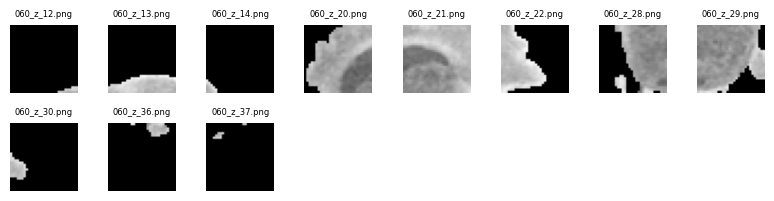

In [ ]:
# Create a figure and a grid of subplots (8x8)
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(8,8, figure=fig)

# Loop through and display each image
for i in range(len(final_ids)):
    path = os.path.join(based_path_tumor, final_ids[i])
    image = cv2.imread(path)
    ax = fig.add_subplot(gs[i])
    ax.imshow(image,cmap="gray")
    ax.set_title(final_ids[i], fontsize=6)
    ax.axis("off")

plt.tight_layout()
plt.show()


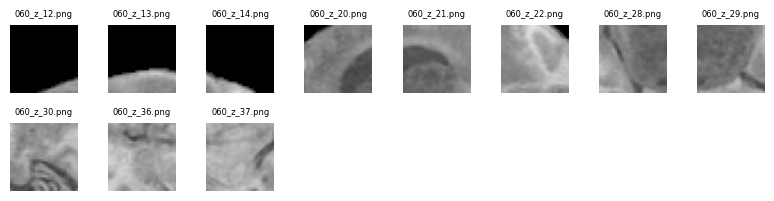

In [ ]:
# Create a figure and a grid of subplots (8x8)
fig = plt.figure(figsize=(8, 8))
gs = GridSpec(8, 8, figure=fig)

# Loop through and display each image
for i in range(len(final_ids)):
    path = os.path.join(based_path_brain_with_tumor, final_ids[i])
    image = cv2.imread(path)
    ax = fig.add_subplot(gs[i])
    ax.imshow(image,cmap="gray")
    ax.set_title(final_ids[i], fontsize=6)
    ax.axis("off")

plt.tight_layout()  # Ensure proper layout
plt.show()  # Display the grid of images


In [ ]:
data_path = []
data_ids = []
#desired_width = 30
#desired_height = 30
for i in range(len(final_ids)):
    filename = final_ids[i]
    path = os.path.join(based_path_brain_with_tumor,final_ids[i])
    img_data = cv2.imread(path)
    gray_image = cv2.cvtColor(img_data, cv2.COLOR_BGR2GRAY)
    #resized_image = cv2.resize(gray_image, (desired_width, desired_height), interpolation=cv2.INTER_LINEAR)
    if 'z_' in filename and '.png' in filename:
        test1 = filename.split('z_')[1]
        test = test1.split('.png')[0]
        data_path.append(gray_image)
        data_ids.append(int(test))

data_column = {'image_data': data_path,
        'class': data_ids}
data_set = pd.DataFrame(data_column)

In [ ]:
data_list = data_set['image_data'].tolist()
classes = data_set['class'].tolist()

In [ ]:
my_array = np.array(data_list)
y_data = np.array(classes)

In [ ]:
my_array.shape

(679, 30, 30)

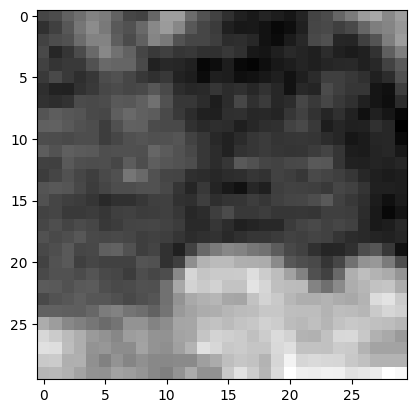

In [ ]:
from tensorflow.keras.utils import normalize

x_train = normalize(my_array, axis=1)
plt.imshow(x_train[1], cmap =plt.cm.binary)

In [ ]:
x_train = np.array(x_train).reshape(-1,30,30,1)
print(x_train.shape)

(679, 30, 30, 1)


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Detection models /along z/Detectionmodel1.hdf5')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf

learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=15
                             )
checkpointer = ModelCheckpoint(filepath="clf-resnet-weights.hdf5",
                               verbose=1,
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=5,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [ ]:
prediction = model.predict(x_train)

22/22 [==============================] - 0s 4ms/step


In [ ]:
test = final_ids[0].split('_')[2].split('.png')[0]
test

'21'

In [ ]:
count = 0
correct_ids = []

for i in range(len(final_ids)):
    prediction_index = np.argmax(prediction[i])
    true_label = int(final_ids[i].split('_')[2].split('.png')[0])

    if prediction_index == true_label:
        count += 1
        correct_ids.append(final_ids[i])

print(f"percentage of correct predictions: {(count/len(final_ids))*100}")
print("List of correct indices:", correct_ids)



percentage of correct predictions: 58.32106038291606
List of correct indices: ['109_z_29.png', '110_z_29.png', '093_z_20.png', '093_z_21.png', '093_z_22.png', '093_z_27.png', '093_z_29.png', '094_z_20.png', '094_z_21.png', '094_z_22.png', '094_z_27.png', '094_z_28.png', '094_z_29.png', '094_z_37.png', '095_z_20.png', '095_z_21.png', '095_z_22.png', '095_z_27.png', '095_z_28.png', '095_z_29.png', '095_z_36.png', '095_z_37.png', '096_z_20.png', '096_z_21.png', '096_z_22.png', '096_z_27.png', '096_z_28.png', '096_z_37.png', '097_z_20.png', '097_z_21.png', '097_z_22.png', '097_z_28.png', '097_z_29.png', '097_z_37.png', '098_z_20.png', '098_z_21.png', '098_z_22.png', '098_z_28.png', '098_z_29.png', '099_z_20.png', '099_z_21.png', '099_z_22.png', '099_z_28.png', '099_z_29.png', '099_z_30.png', '100_z_20.png', '100_z_21.png', '100_z_22.png', '100_z_28.png', '100_z_30.png', '101_z_20.png', '101_z_22.png', '101_z_28.png', '101_z_30.png', '102_z_20.png', '102_z_22.png', '102_z_28.png', '102_z_30